# Preprocessing

### Read about coord systems at https://www.slicer.org/wiki/Coordinate_systems

note to self: สรุป : DICOM and ITK ใช้ LPS coord system (left pos sup)

origin = first voxel (0,0,0) in anatomical coord eg 100mm, 50mm, -25mm

spacing = distance between voxels along each axis, e.g. (1.5mm, 0.5mm, 0.5mm)

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import dicom
import scipy.misc
import SimpleITK as sitk
import random
import cv2
import time

C:\Users\Mark\anaconda3\lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [3]:
with open("annotations.csv") as file:
    annotations = pd.read_csv(file)    
with open("candidates_V2.csv") as file:
    candidates = pd.read_csv(file)
false_pos_candidates = candidates[candidates["class"] == 0]

### Adapted segmentation code mostly from https://www.kaggle.com/arnavkj95/candidate-generation-and-luna16-preprocessing

In [4]:
'''
This funciton reads a '.mhd' file using SimpleITK and return the image array, 
origin and spacing of the image.
'''
def load_itk(filename):
    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)
    
    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)
    
    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))
    
    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))
    
    return ct_scan, origin, spacing

'''
This function is used to convert the world coordinates to voxel coordinates using 
the origin and spacing of the ct_scan
'''
def world_2_voxel(world_coordinates, origin, spacing):
    stretched_voxel_coordinates = np.absolute(world_coordinates - origin)
    voxel_coordinates = stretched_voxel_coordinates / spacing
    return voxel_coordinates

'''
This function is used to convert the voxel coordinates to world coordinates using 
the origin and spacing of the ct_scan.
'''
def voxel_2_world(voxel_coordinates, origin, spacing):
    stretched_voxel_coordinates = voxel_coordinates * spacing
    world_coordinates = stretched_voxel_coordinates + origin
    return world_coordinates

In [8]:
""" Apply Maximum intensity projection https://radiopaedia.org/articles/maximum-intensity-projection   
Since Z is not constant between each CT scan (eg. 231, 245), 
but we want an output with z=64, some slices need to be "thicker" (round up) or "thinner" (round down)
"""  
def apply_MIP_over_z(img, output_z=64):
    z = img.shape[0]
    new_img = np.zeros((output_z,img.shape[1],img.shape[2]))
    denominator_up = int(np.ceil(z/output_z))
    denominator_down = int(np.floor(z/output_z))
    a_list = random.sample(range(output_z), z%output_z)
    num = 0
    
    for i in range(output_z):
        if i in a_list:
            previous_num = num
            num += denominator_up
            selected = img[previous_num:num,:,:]
            new_img[i] = np.max(selected, axis=0)
        else:
            previous_num = num
            num += denominator_down
            selected = img[previous_num:num,:,:]
            new_img[i] = np.max(selected, axis=0)
    return new_img


""" according to Fangzhou Liao, the threshold for max HU of interests is 400 (will exclude bone and calcified nodule)
 min bound is -1000, the mean HU of the entire dataset is 0.25 """
MIN_BOUND = -1000.0
MAX_BOUND = 400.0
    
def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

PIXEL_MEAN = 0.25
def zero_center(image):
    image = image - PIXEL_MEAN
    return image

In [9]:
# output list of list of chunks from the CT scan, if chunks = 8 will return 64 chunks
def get_chunks(image, chunks = 16):
    output = []
    list_z = np.split(image, 4, axis=1)
    for z in list_z:
        list_y = np.split(z, chunks, axis=2)
        for y in list_y:
            list_x = np.split(y, chunks, axis=3)
            for chunk in list_x:
                output.append(chunk)
    return output    


In [11]:
# output positive chunks (contain labels) only,
def get_pos_chunks(image, chunks = 16):
    output = []
    list_z = np.split(image, 4, axis=1)
    for z in list_z:
        list_y = np.split(z, chunks, axis=2)
        for y in list_y:
            list_x = np.split(y, chunks, axis=3)
            for chunk in list_x:
                if np.sum(chunk[1])>100:
                    output.append(chunk)           

    return output    

In [12]:
def seq(start, stop, step=1):
    n = int(round((stop - start)/float(step)))
    if n > 1:
        return([start + step*i for i in range(n+1)])
    else:
        return([])

# First generator

will generate pos_chunk

In [13]:
'''
This function is used to create spherical regions in binary masks
at the given locations and radius.
'''
def draw_circles(image,cands,origin,spacing):
    #make empty matrix, which will be filled with the mask
    RESIZE_SPACING = [1, 1, 1]
    image_mask = np.zeros(image.shape)

    #run over all the nodules in the lungs
    for ca in cands.values:
        #get middle x-,y-, and z-worldcoordinate of the nodule
        radius = np.ceil(ca[4])/2
        coord_x = ca[1]
        coord_y = ca[2]
        coord_z = ca[3]
        image_coord = np.array((coord_z,coord_y,coord_x))

        #determine voxel coordinate given the worldcoordinate
        image_coord = world_2_voxel(image_coord,origin,spacing)

        #determine the range of the nodule
        noduleRange = seq(-radius, radius, RESIZE_SPACING[0])

        #create the mask
        #vector norm = size of vector, x y z will create a box -- limiting it to a radius will create a sphere
        for x in noduleRange:
            for y in noduleRange:
                for z in noduleRange:
                    coords = world_2_voxel(np.array((coord_z+z,coord_y+y,coord_x+x)),origin,spacing)
                    coords = coords.astype(int)
                    if (np.linalg.norm(image_coord-coords) * RESIZE_SPACING[0]) < radius:
                        image_mask[np.round(coords[0]),np.round(coords[1]),np.round(coords[2])] = int(1)

    return image_mask

'''
This function takes the path to a '.mhd' file as input and 
is used to create the nodule masks and segmented lungs after 
rescaling to 1mm size in all directions. It saved them in the .npy
format. It also takes the list of nodule locations in that CT Scan as 
input.
'''
def create_nodule_mask(imagePath, maskPath, cands):
    #if os.path.isfile(imagePath.replace('original',SAVE_FOLDER_image)) == False:
    img, origin, spacing = load_itk(imagePath)

    #calculate resize factor("real_resize")
    RESIZE_SPACING = [1, 1, 1]
    resize_factor = spacing / RESIZE_SPACING
    new_real_shape = img.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize = new_shape / img.shape
    new_spacing = spacing / real_resize
    
    #resize image (zoom by a factor of real_resize)
    lung_img = scipy.ndimage.interpolation.zoom(img, real_resize)
    
    #create nodule mask
    nodule_mask = draw_circles(lung_img,cands,origin,new_spacing)

    lung_mask_512, nodule_mask_512 = np.zeros((lung_img.shape[0], 512, 512)), np.zeros((nodule_mask.shape[0], 512, 512))

    original_shape = lung_img.shape
    for z in range(lung_img.shape[0]):
        offset = (512 - original_shape[1])
        upper_offset = int(np.round(offset/2))
        lower_offset = int(offset - upper_offset)

        new_origin = voxel_2_world([-upper_offset,-lower_offset,0],origin,new_spacing)

        lung_mask_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = lung_img[z,:,:]
        nodule_mask_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = nodule_mask[z,:,:]
        
#   resize and apply MIP
    lung_mask_512 = apply_MIP_over_z(lung_mask_512, output_z=128)
    nodule_mask_512 = apply_MIP_over_z(nodule_mask_512, output_z=128)
    
#     normalize and zero_center
    lung_mask_512 = normalize(lung_mask_512)
    lung_mask_512 = zero_center(lung_mask_512)
    
#   create classes 0=img, 1=mask, 2=neg_mask
    class_image = np.zeros(2*128*512*512).reshape(2,128,512,512)
    class_image[0],class_image[1] = lung_mask_512,nodule_mask_512

    
#   chunk the image into 3,64,64,64 of about 64 images then get only the chunk with nodule in it
    chunks = get_pos_chunks(class_image)


#    save images.    
    imageName = imagePath.split('/')[1][:-4]
    for i,chunk in enumerate(chunks):
        np.save(os.path.join(maskPath, imageName+ '_pos_chunk_{}'.format(i)), chunk)


In [13]:
start_time = time.time()
for i in range(0,9):
    subset = "subset{}".format(i)

    file_list = [s for s in os.listdir(subset) if s[:][-4:]==".mhd"]
    mask_path = "train5"
    for i in file_list:
        img_dir = subset + '/' + i
        cands = annotations[annotations["seriesuid"] == i[:][:-4]]
        create_nodule_mask(img_dir, mask_path, cands)
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 12605.088758468628 seconds ---


In [14]:
start_time = time.time()
for i in range(9,10):
    subset = "subset{}".format(i)

    file_list = [s for s in os.listdir(subset) if s[:][-4:]==".mhd"]
    mask_path = "test5"
    for i in file_list:
        img_dir = subset + '/' + i
        cands = annotations[annotations["seriesuid"] == i[:][:-4]]
        create_nodule_mask(img_dir, mask_path, cands)
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 1347.3688297271729 seconds ---


### Visualizing

Visualize in ipywidegets

In [14]:
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
#  find indices of labeled slices.
test_img = np.load("train4/1.3.6.1.4.1.14519.5.2.1.6279.6001.133378195429627807109985347209_seg_pos_chunk_2.npy")
a = np.sum(test_img[1])
print(a)
print(test_img.shape)
layer_i = []
for i in range(test_img.shape[1]):
    test_mask = test_img[1,i, :, :]
    if np.sum(test_mask)>0:
        layer_i.append(i)
layer_i

655.0
(2, 32, 32, 32)


[6, 7, 8, 9, 10, 11, 12]

In [25]:
test_img = test_img
def explore_3dimage(layer = layer_i[1]):
    plt.figure(figsize=(10, 5))
    plt.imshow(test_img[0 ,layer, :, :], cmap='gray');
    test_mask = test_img[1 ,layer, :, :]
    print(test_mask.shape)
    test_mask = np.ma.masked_where(test_mask <0.05, test_mask)
    plt.imshow(test_mask[:, :], cmap="hsv", alpha=0.5);
    plt.title('Chunk', fontsize=20)
#     plt.axis('off')
    return layer
interact(explore_3dimage, layer=(0, test_img.shape[1]));

interactive(children=(IntSlider(value=7, description='layer', max=32), Output()), _dom_classes=('widget-intera…

<Figure size 720x360 with 0 Axes>

# second generator

This will create false positive candidates from the coords already provided with LUNA 16 dataset.

In [16]:
def draw_square(image,cand,origin,spacing):
    #make empty matrix, which will be filled with the mask
    RESIZE_SPACING = [1, 1, 1]

    #get middle x-,y-, and z-worldcoordinate of the false nodule
    l = 16 #length from coord_xyz to the edge.  length 32 will get 64x64x64 chunk
    coord_x_b = cand[1]
    coord_y_b = cand[2]
    coord_z_b = cand[3]
    image_coord = np.array((coord_z_b,coord_y_b,coord_x_b))

    #determine voxel coordinate given the worldcoordinate
    image_coord = world_2_voxel(image_coord,origin,spacing)
    coord_x = image_coord[0].astype(int)
    coord_y = image_coord[1].astype(int)
    coord_z = image_coord[2].astype(int)

    # sometimes the coords are at the rim of the images.. 
    if coord_z>image.shape[0]:
        print('coord_z>image.shape[0]',coord_z,image.shape[0])
        coord_z -= 2*(coord_z-image.shape[0])

    #create the mask, left the z layer as is, as this will be compressed into size 64 later
    chunk = image[coord_z-l:coord_z+l, coord_y-l:coord_y+l, coord_x-l:coord_x+l]
    return chunk


def create_false_nodule_mask(imagePath, maskPath, list_of_cands):
    #if os.path.isfile(imagePath.replace('original',SAVE_FOLDER_image)) == False:
    img, origin, spacing = load_itk(imagePath)
    
    #calculate resize factor("real_resize")
    RESIZE_SPACING = [1, 1, 1]
    resize_factor = spacing / RESIZE_SPACING
    new_real_shape = img.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize = new_shape / img.shape
    new_spacing = spacing / real_resize
    
    #resize image (zoom by a factor of real_resize)
    lung_img = scipy.ndimage.interpolation.zoom(img, real_resize)
    
    #create a 64x64x64 chunk of false nodule mask
    imageName = imagePath.split('/')[1][:-4]
    
    for i,cand in enumerate(list_of_cands.values):
        chunk = draw_square(lung_img,cand,origin,new_spacing)
    # normalize and zero_center
        chunk = normalize(chunk)
        chunk = zero_center(chunk)
        
        chunk_nodule_mask = np.zeros((32,32,32))
        class_image = np.zeros(2*32*32*32).reshape(2,32,32,32)

        try:
            class_image[0],class_image[1] = chunk,chunk_nodule_mask
            np.save(os.path.join(maskPath, imageName+ '_false_{}'.format(i)), class_image)
            
        except:
            continue

ลองดู candidateใน false pos cand แล้วดูว่าจะยัดลงไปยังไง

In [22]:
start_time = time.time()
for i in range(8,9):
    subset = "subset{}".format(i)
    file_list = [s for s in os.listdir(subset) if s[:][-4:]==".mhd"]
    mask_path = "false_cand"
    for i in file_list:
        img_dir = subset + '/' + i
        false_pos_cands = false_pos_candidates[false_pos_candidates["seriesuid"] == i[:][:-4]]
#     randomly sample no more than 5 coords from false pos can 
#         if len(false_pos_cands)>5 :
#             false_pos_cands = false_pos_cands.sample(n=5)
        create_false_nodule_mask(img_dir, mask_path, false_pos_cands)
    
print("--- %s seconds ---" % (time.time() - start_time))

coord_z>image.shape[0] 274 272
coord_z>image.shape[0] 290 272
coord_z>image.shape[0] 292 272
coord_z>image.shape[0] 276 272
coord_z>image.shape[0] 316 272
coord_z>image.shape[0] 286 272
coord_z>image.shape[0] 309 272
coord_z>image.shape[0] 292 272
coord_z>image.shape[0] 289 272
coord_z>image.shape[0] 273 272
coord_z>image.shape[0] 295 272
coord_z>image.shape[0] 313 272
coord_z>image.shape[0] 314 272
coord_z>image.shape[0] 297 272
coord_z>image.shape[0] 273 272
coord_z>image.shape[0] 281 272
coord_z>image.shape[0] 301 272
coord_z>image.shape[0] 286 272
coord_z>image.shape[0] 325 272
coord_z>image.shape[0] 278 272
coord_z>image.shape[0] 275 272
coord_z>image.shape[0] 285 272
coord_z>image.shape[0] 302 272
coord_z>image.shape[0] 297 272
coord_z>image.shape[0] 289 272
coord_z>image.shape[0] 315 272
coord_z>image.shape[0] 281 272
coord_z>image.shape[0] 313 272
coord_z>image.shape[0] 314 272
coord_z>image.shape[0] 288 272
coord_z>image.shape[0] 276 272
coord_z>image.shape[0] 288 272
coord_z>

coord_z>image.shape[0] 336 315
coord_z>image.shape[0] 321 315
coord_z>image.shape[0] 319 315
coord_z>image.shape[0] 319 315
coord_z>image.shape[0] 326 315
coord_z>image.shape[0] 323 315
coord_z>image.shape[0] 329 315
coord_z>image.shape[0] 331 315
coord_z>image.shape[0] 332 315
coord_z>image.shape[0] 316 315
coord_z>image.shape[0] 334 315
coord_z>image.shape[0] 325 315
coord_z>image.shape[0] 316 315
coord_z>image.shape[0] 341 315
coord_z>image.shape[0] 355 315
coord_z>image.shape[0] 362 315
coord_z>image.shape[0] 317 315
coord_z>image.shape[0] 317 315
coord_z>image.shape[0] 348 315
coord_z>image.shape[0] 316 315
coord_z>image.shape[0] 327 315
coord_z>image.shape[0] 330 315
coord_z>image.shape[0] 332 315
coord_z>image.shape[0] 324 315
coord_z>image.shape[0] 334 315
coord_z>image.shape[0] 320 315
coord_z>image.shape[0] 348 315
coord_z>image.shape[0] 352 315
coord_z>image.shape[0] 352 315
coord_z>image.shape[0] 348 321
coord_z>image.shape[0] 352 321
coord_z>image.shape[0] 323 321
coord_z>

coord_z>image.shape[0] 339 332
coord_z>image.shape[0] 351 332
coord_z>image.shape[0] 362 332
coord_z>image.shape[0] 355 332
coord_z>image.shape[0] 349 332
coord_z>image.shape[0] 368 332
coord_z>image.shape[0] 359 332
coord_z>image.shape[0] 352 332
coord_z>image.shape[0] 363 332
coord_z>image.shape[0] 336 332
coord_z>image.shape[0] 333 332
coord_z>image.shape[0] 365 332
coord_z>image.shape[0] 333 332
coord_z>image.shape[0] 339 332
coord_z>image.shape[0] 340 332
coord_z>image.shape[0] 366 332
coord_z>image.shape[0] 335 332
coord_z>image.shape[0] 343 332
coord_z>image.shape[0] 351 332
coord_z>image.shape[0] 347 332
coord_z>image.shape[0] 363 332
coord_z>image.shape[0] 356 332
coord_z>image.shape[0] 362 332
coord_z>image.shape[0] 344 332
coord_z>image.shape[0] 355 332
coord_z>image.shape[0] 363 332
coord_z>image.shape[0] 366 332
coord_z>image.shape[0] 361 332
coord_z>image.shape[0] 360 332
coord_z>image.shape[0] 354 332
coord_z>image.shape[0] 338 332
coord_z>image.shape[0] 347 332
coord_z>

coord_z>image.shape[0] 295 272
coord_z>image.shape[0] 279 272
coord_z>image.shape[0] 311 272
coord_z>image.shape[0] 295 272
coord_z>image.shape[0] 328 272
coord_z>image.shape[0] 302 272
coord_z>image.shape[0] 298 272
coord_z>image.shape[0] 284 272
coord_z>image.shape[0] 283 272
coord_z>image.shape[0] 323 272
coord_z>image.shape[0] 282 272
coord_z>image.shape[0] 298 272
coord_z>image.shape[0] 304 272
coord_z>image.shape[0] 288 272
coord_z>image.shape[0] 284 272
coord_z>image.shape[0] 304 272
coord_z>image.shape[0] 302 272
coord_z>image.shape[0] 274 272
coord_z>image.shape[0] 301 272
coord_z>image.shape[0] 295 272
coord_z>image.shape[0] 273 272
coord_z>image.shape[0] 278 272
coord_z>image.shape[0] 296 272
coord_z>image.shape[0] 305 272
coord_z>image.shape[0] 294 272
coord_z>image.shape[0] 288 272
coord_z>image.shape[0] 300 272
coord_z>image.shape[0] 274 272
coord_z>image.shape[0] 315 272
coord_z>image.shape[0] 304 272
coord_z>image.shape[0] 276 272
coord_z>image.shape[0] 297 272
coord_z>

coord_z>image.shape[0] 346 332
coord_z>image.shape[0] 344 332
coord_z>image.shape[0] 339 332
coord_z>image.shape[0] 351 332
coord_z>image.shape[0] 344 332
coord_z>image.shape[0] 368 332
coord_z>image.shape[0] 351 332
coord_z>image.shape[0] 351 332
coord_z>image.shape[0] 339 332
coord_z>image.shape[0] 340 332
coord_z>image.shape[0] 334 332
coord_z>image.shape[0] 347 332
coord_z>image.shape[0] 353 332
coord_z>image.shape[0] 348 332
coord_z>image.shape[0] 357 332
coord_z>image.shape[0] 362 332
coord_z>image.shape[0] 334 332
coord_z>image.shape[0] 339 332
coord_z>image.shape[0] 344 332
coord_z>image.shape[0] 367 332
coord_z>image.shape[0] 340 332
coord_z>image.shape[0] 339 332
coord_z>image.shape[0] 334 332
coord_z>image.shape[0] 345 332
coord_z>image.shape[0] 359 332
coord_z>image.shape[0] 353 332
coord_z>image.shape[0] 333 332
coord_z>image.shape[0] 337 332
coord_z>image.shape[0] 336 332
coord_z>image.shape[0] 349 332
coord_z>image.shape[0] 345 332
coord_z>image.shape[0] 349 332
coord_z>

coord_z>image.shape[0] 333 332
coord_z>image.shape[0] 339 332
coord_z>image.shape[0] 345 342
coord_z>image.shape[0] 345 342
coord_z>image.shape[0] 355 342
coord_z>image.shape[0] 350 342
coord_z>image.shape[0] 349 342
coord_z>image.shape[0] 344 342
coord_z>image.shape[0] 344 342
coord_z>image.shape[0] 356 342
coord_z>image.shape[0] 356 336
coord_z>image.shape[0] 342 336
coord_z>image.shape[0] 356 336
coord_z>image.shape[0] 337 336
coord_z>image.shape[0] 350 336
coord_z>image.shape[0] 341 336
coord_z>image.shape[0] 337 336
coord_z>image.shape[0] 343 336
coord_z>image.shape[0] 343 336
coord_z>image.shape[0] 360 336
coord_z>image.shape[0] 347 336
coord_z>image.shape[0] 341 336
coord_z>image.shape[0] 338 336
coord_z>image.shape[0] 346 336
coord_z>image.shape[0] 341 336
coord_z>image.shape[0] 337 336
coord_z>image.shape[0] 340 336
coord_z>image.shape[0] 345 336
coord_z>image.shape[0] 349 336
coord_z>image.shape[0] 356 336
coord_z>image.shape[0] 342 336
coord_z>image.shape[0] 343 336
coord_z>

coord_z>image.shape[0] 295 242
coord_z>image.shape[0] 264 242
coord_z>image.shape[0] 293 242
coord_z>image.shape[0] 252 242
coord_z>image.shape[0] 255 242
coord_z>image.shape[0] 296 242
coord_z>image.shape[0] 262 242
coord_z>image.shape[0] 296 242
coord_z>image.shape[0] 264 242
coord_z>image.shape[0] 290 242
coord_z>image.shape[0] 302 242
coord_z>image.shape[0] 289 242
coord_z>image.shape[0] 244 242
coord_z>image.shape[0] 286 242
coord_z>image.shape[0] 305 242
coord_z>image.shape[0] 245 242
coord_z>image.shape[0] 250 242
coord_z>image.shape[0] 314 242
coord_z>image.shape[0] 253 242
coord_z>image.shape[0] 274 242
coord_z>image.shape[0] 291 242
coord_z>image.shape[0] 269 242
coord_z>image.shape[0] 286 242
coord_z>image.shape[0] 290 242
coord_z>image.shape[0] 263 242
coord_z>image.shape[0] 266 242
coord_z>image.shape[0] 266 242
coord_z>image.shape[0] 269 242
coord_z>image.shape[0] 293 242
coord_z>image.shape[0] 307 242
coord_z>image.shape[0] 259 242
coord_z>image.shape[0] 286 242
coord_z>

### Visualize like before..

In [51]:
# test_false = np.load("false_cand/1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059_false_0.npy")
# test_false.shape

(2, 32, 32, 32)

In [54]:
# from ipywidgets import interact, interactive, IntSlider, ToggleButtons
# import matplotlib.pyplot as plt
# %matplotlib inline

In [ ]:
# test_img = test_false
# def explore_3dimage(layer):
#     plt.figure(figsize=(10, 5))
#     plt.imshow(test_img[0 ,layer, :, :], cmap='gray');
#     test_mask = test_img[1 ,layer, :, :]
#     print(test_mask.shape)
#     test_mask = np.ma.masked_where(test_mask <0.05, test_mask)
#     plt.imshow(test_mask[:, :], cmap="hsv", alpha=0.5);
#     plt.title('Chunk', fontsize=20)
# #     plt.axis('off')
#     return layer
# interact(explore_3dimage, layer=(0, test_img.shape[1]));

# Third generator
This generates 1024 chunks of lung_mask segmented from 1 CT scan - will use this to reduce false positive when input entire CT scan into the model 

In [20]:
def create_large_mask(imagePath, maskPath, cands):
    #if os.path.isfile(imagePath.replace('original',SAVE_FOLDER_image)) == False:
    img, origin, spacing = load_itk(imagePath)

    #calculate resize factor("real_resize")
    RESIZE_SPACING = [1, 1, 1]
    resize_factor = spacing / RESIZE_SPACING
    new_real_shape = img.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize = new_shape / img.shape
    new_spacing = spacing / real_resize
    
    #resize image (zoom by a factor of real_resize)
    lung_img = scipy.ndimage.interpolation.zoom(img, real_resize)
        
    #create nodule mask
    nodule_mask = draw_circles(lung_img,cands,origin,new_spacing)

    lung_mask_512, nodule_mask_512 = np.zeros((lung_img.shape[0], 512, 512)), np.zeros((nodule_mask.shape[0], 512, 512))

    original_shape = lung_img.shape
    for z in range(lung_img.shape[0]):
        offset = (512 - original_shape[1])
        upper_offset = int(np.round(offset/2))
        lower_offset = int(offset - upper_offset)

        new_origin = voxel_2_world([-upper_offset,-lower_offset,0],origin,new_spacing)

        lung_mask_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = lung_mask[z,:,:]
        nodule_mask_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = nodule_mask[z,:,:]
        
#   resize and apply MIP
    lung_mask_512 = apply_MIP_over_z(lung_mask_512, output_z=128)
    nodule_mask_512 = apply_MIP_over_z(nodule_mask_512, output_z=128)
    
#     normalize and zero_center
    lung_mask_512 = normalize(lung_mask_512)
    lung_mask_512 = zero_center(lung_mask_512)
    
#   create classes 0=img, 1=mask,
    class_image = np.zeros(2*128*512*512).reshape(2,128,512,512)
    class_image[0],class_image[1] = lung_mask_512,nodule_mask_512

    
#   chunk the image into 2,64,64,64 of about 64 images then get only the chunk with nodule in it
    """This is the only difference from 1st generator"""
    chunks = get_chunks(class_image)

#    save images.    
    imageName = imagePath.split('/')[1][:-4]
    for i,chunk in enumerate(chunks):
        np.save(os.path.join(maskPath, imageName+ '_big_{}'.format(i)), chunk)

In [21]:
# since this only creates 1024 mask images from a single CT.
start_time = time.time()

big_img_path = "subset9/1.3.6.1.4.1.14519.5.2.1.6279.6001.124822907934319930841506266464.mhd"
pos_cands = annotations[annotations["seriesuid"] == "1.3.6.1.4.1.14519.5.2.1.6279.6001.124822907934319930841506266464"]
create_large_mask(big_img_path, "train5-big", pos_cands)

print("--- %s seconds ---" % (time.time() - start_time))

KeyboardInterrupt: 

# Preprocess an actual test scan without chunking into small pieces.

Lastly make a test set, but this time make it just like when you are deploying the model on an actual CT scan..
- i.e. MIP into 128x512x512 without chunks and save..
- when load: Just chunk it into 32x32x32 before input into model and reassemble the image back again

In [14]:
def create_test_mask(imagePath, maskPath, cands):
    #if os.path.isfile(imagePath.replace('original',SAVE_FOLDER_image)) == False:
    img, origin, spacing = load_itk(imagePath)

    #calculate resize factor("real_resize")
    RESIZE_SPACING = [1, 1, 1]
    resize_factor = spacing / RESIZE_SPACING
    new_real_shape = img.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize = new_shape / img.shape
    new_spacing = spacing / real_resize
    
    #resize image (zoom by a factor of real_resize)
    lung_img = scipy.ndimage.interpolation.zoom(img, real_resize)

    #create nodule mask
    nodule_mask = draw_circles(lung_img,cands,origin,new_spacing)

    lung_img_512, nodule_mask_512 = np.zeros((lung_img.shape[0], 512, 512)), np.zeros((nodule_mask.shape[0], 512, 512))

    original_shape = lung_img.shape
    for z in range(lung_img.shape[0]):
        offset = (512 - original_shape[1])
        upper_offset = int(np.round(offset/2))
        lower_offset = int(offset - upper_offset)

        new_origin = voxel_2_world([-upper_offset,-lower_offset,0],origin,new_spacing)

        lung_img_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = lung_img[z,:,:]

        nodule_mask_512[z, upper_offset:-lower_offset,upper_offset:-lower_offset] = nodule_mask[z,:,:]
        
#   resize and apply MIP
    lung_img_512 = apply_MIP_over_z(lung_img_512, output_z=128)
    nodule_mask_512 = apply_MIP_over_z(nodule_mask_512, output_z=128)
        
#   normalize and zero_center
    lung_img_512 = normalize(lung_img_512)
    lung_img_512 = zero_center(lung_img_512)
    
#   create classes 0=img, 1=mask, 2=neg_mask
    class_image = np.zeros(2*128*512*512).reshape(2,128,512,512)
    class_image[0],class_image[1] = lung_img_512 ,nodule_mask_512 #ใส่ lung_img ไว้หลังสุด ตอนแก้ model จะได้ไม่ปวดหัว

#     save images.    
    imageName = imagePath.split('/')[1][:-4]
    np.save(os.path.join(maskPath, imageName+ '_test'), class_image)


In [15]:
start_time = time.time()

subset = "subset9"

file_list = [s for s in os.listdir(subset) if s[:][-4:]==".mhd"]
mask_path = "test5-big"
for i in file_list:
    img_dir = subset + '/' + i
    cands = annotations[annotations["seriesuid"] == i[:][:-4]]
    create_test_mask(img_dir, mask_path, cands)
    
print("--- %s seconds ---" % (time.time() - start_time))

KeyboardInterrupt: 

### Visualize again..

In [14]:
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
test_img = np.load("test3/1.3.6.1.4.1.14519.5.2.1.6279.6001.129650136453746261130135157590_test.npy")
a = np.sum(test_img[1])
print(a)
print(test_img.shape)

0.0
(2, 128, 512, 512)


In [30]:
test_img = test_img
def explore_3dimage(layer=62):
    plt.figure(figsize=(15, 15))
    plt.imshow(test_img[0 ,layer, :, :], cmap='gray');
    test_mask = test_img[1 ,layer, :, :]
    print(test_mask.shape)
    test_mask = np.ma.masked_where(test_mask <0.05, test_mask)
    plt.imshow(test_mask[:, :], cmap="hsv", alpha=0.5);
    plt.title('Chunk', fontsize=20)
    plt.axis('off')
    return layer


In [31]:
interact(explore_3dimage, layer=(0, test_img.shape[1]));

interactive(children=(IntSlider(value=62, description='layer', max=128), Output()), _dom_classes=('widget-inte…

### A useful code to plot and check if the output is centered and normalized.

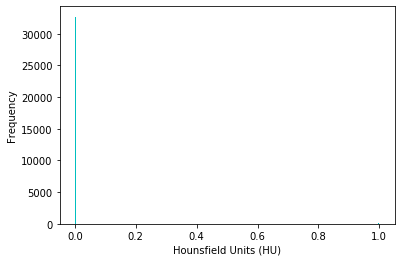

In [24]:
# plt.hist(test_img[1].flatten(), bins=200, color='c')
# plt.xlabel("Hounsfield Units (HU)")
# plt.ylabel("Frequency")
# plt.show()